# Gaia DR3 Data for Ursa Major

## Still Frames

Draw still frames of the apperance of the Big Dipper asterism (aka Ursa Major) using Gaia DR3 stars.  The
first plot is the present day, the second plot is how you setup any date to view the constellation in
time in years AD or BC (aka CE or BCE).

The constellation stars are primarily drawn from the Hipparcos catalog since they are too bright for Gaia, and
stored in a standalne data file.

Gaia stars are retrieved at the start of the notebook from the Gaia Archive using the `astroquery.gaia` 
module which uses the Gaia TAP+ query styl.e

### Notes

Based on the Gaia Archive tutorial (located at the Gaia Archive, http://archives.esac.esa.int/gaia -> Help -> Tutorials -> Cluster analysis ) and adapted it to python.
The tutorial uses the Gaia TAP+ (astroquery.gaia) module, http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#module-astroquery.gaia 


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import math
import time
import numpy as np
import pandas as pd

# astropy modules for coordinates, time, uhits, and Gaia queries

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time

from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.utils.tap import TapPlus

# Suppress warnings. Comment this out if you wish to see the warning messages

import warnings
warnings.filterwarnings('ignore')

# Gaia Tables

tables = Gaia.load_tables(only_names=True)

# Field center and radius in decimal degrees

dRA = 186.17
dDec = 56.5
searchRad = 15.0*math.sqrt(2)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


## Plotting format

Scale for 4K UHD 3840x2160 at 150dpi

In [20]:
dpi = 150
wDisp = 3840
hDisp = 2160
wInches = float(wDisp)/float(dpi)
hInches = float(hDisp)/float(dpi)
aspect = wDisp/hDisp

# default font size

fontSize = 16
matplotlib.rcParams.update({'font.size':fontSize})

matplotlib.rcParams['xtick.major.pad']=0
matplotlib.rcParams['ytick.major.pad']=0
matplotlib.rcParams['axes.labelpad']=0

## Gaia data query

Perform an asynchronous query centered on the nominal field center of UMa (`dRA` and `dDec`) with a search
radius of `searchRad` degrees.

Note: The query to the archive is with ADQL (Astronomical Data Query Language). For a description of ADQL and more examples see the Gaia DR1 ADQL cookbook: https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook

Search limits:
 * g mag between 3.0 and 10.0mag (change with `brightMag` and `faintMag` below)
 * error in proper motions <10%
 * stars with valid parallaxes and proper motions (not null or parallax <=0)

In [21]:
brightMag = 3.0
faintMag = 10.0

gQuery=f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{dRA},{dDec},{searchRad}))=1
AND phot_g_mean_mag BETWEEN {brightMag:.1f} and {faintMag:.1f}
AND abs(pmra_error/pmra)<0.10
AND abs(pmdec_error/pmdec)<0.10
AND parallax IS NOT NULL AND parallax>0
AND pmra IS NOT NULL AND abs(pmra)>0
AND pmdec IS NOT NULL AND abs(pmdec)>0
"""

#print(gQuery)

print('Launching Gaia DR3 query...')

t0 = time.time()
job = Gaia.launch_job_async(gQuery)
j = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(j)} stars (query took {dt:.1f} seconds)')

# old-school way to do this

#job = Gaia.launch_job_async("SELECT * \
#FROM gaiadr3.gaia_source \
#WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',%f,%f,%f))=1 \
#AND phot_g_mean_mag BETWEEN 3.0 and 10.0 \
#AND abs(pmra_error/pmra)<0.10 \
#AND abs(pmdec_error/pmdec)<0.10 \
#AND parallax IS NOT NULL AND parallax>0 \
#AND pmra IS NOT NULL AND abs(pmra)>0 \
#AND pmdec IS NOT NULL AND abs(pmdec)>0;" % (dRA,dDec,searchRad), dump_to_file=True)

Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 7624 stars (query took 15.1 seconds)


### Process the Gaia query return

Process the data query returned and build the arrays we'll use.  Give a summary of results.

In [22]:
ra = np.array(j['ra'])
dec = np.array(j['dec'])
parallax = np.array(j['parallax'])
pmra = np.array(j['pmra'])
pmdec = np.array(j['pmdec'])
gMag = np.array(j['phot_g_mean_mag'])
epoch = np.array(j['ref_epoch'])

ms = 2.0*((faintMag+0.05) - gMag)*(100.0/dpi) # magnitude scaling

gaiaEpoch = epoch[0]

#print(np.max(pmra),np.min(pmra))
#print(np.max(pmdec),np.min(pmdec))
#print(np.max(parallax),np.min(parallax))

numStars = len(j)
print(f'Number of stars: {numStars}')
print(f'magnitude range: {np.min(gMag):.2f} to {np.max(gMag):.2f}')
print(f'GAIA DR3 Epoch {gaiaEpoch:.2f}')

Number of stars: 7624
magnitude range: 3.10 to 10.00
GAIA DR3 Epoch 2016.00


## Bright Stars

These are the bright stars that define the Big Dipper asterism.  We are not plotting the entire constellation.
We got these coordinates from a combination of Gaia DR3 for the fainter stars, and Hipparcos for the stars
brigher than the Gaia DR3 limit. 

In [23]:
umaFile = 'UMa_Bright.cat'
data = pd.read_csv(umaFile,sep=r'\s+')

raUMa = np.array(data['ra'])
decUMa = np.array(data['dec'])
parUMa = np.array(data['par'])
pmrUMa = np.array(data['pmra'])
pmdUMa = np.array(data['pmdec'])
magUMa = np.array(data['vMag'])
epUMa = np.array(data['epoch'])
srcUMa = np.array(data['source'])

# represent star brightness withi size: small=faint, large=bright

msUMa = 2.0*((faintMag+0.05) - magUMa)*(100.0/dpi) # magnitude scaling

# full coordinate object for the UMa constellation stars

const = SkyCoord(ra=raUMa*u.deg,dec=decUMa*u.deg,
                 distance=Distance(parallax=parUMa*u.mas),
                 pm_ra_cosdec=pmrUMa*u.mas/u.yr,
                 pm_dec=pmdUMa*u.mas/u.yr,
                 obstime=Time(epUMa,format='decimalyear'),
                 frame='icrs')

# Transform into the Gaia epoch

constel = const.apply_space_motion(Time(gaiaEpoch,format='decimalyear'))

## Transform to ($\xi,\eta$) coordinates

Transform to "offset" ($\xi,\eta$) coordinates (aka "standard coordinates on the tangent plane") for plotting

In [24]:
# coordinate object for the nominal field center

uma = SkyCoord(dRA*u.deg,dDec*u.deg,frame='icrs')

# full coordinate object for the Gaia DR2 stars

stars = SkyCoord(ra=ra*u.deg,
                 dec=dec*u.deg,
                 distance=Distance(parallax=parallax*u.mas,allow_negative=True),
                 pm_ra_cosdec=pmra*u.mas/u.yr,
                 pm_dec=pmdec*u.mas/u.yr,
                 obstime=Time(epoch,format='decimalyear'),
                 frame='icrs')

# Transform field to (xi,eta) coords centered on UMa

skyview = stars.transform_to(uma.skyoffset_frame())
xi = skyview.lon
eta = skyview.lat

# and same for the constellation proper

conUMa = constel.transform_to(uma.skyoffset_frame())
xiUMa = conUMa.lon
etaUMa = conUMa.lat

## Plot it


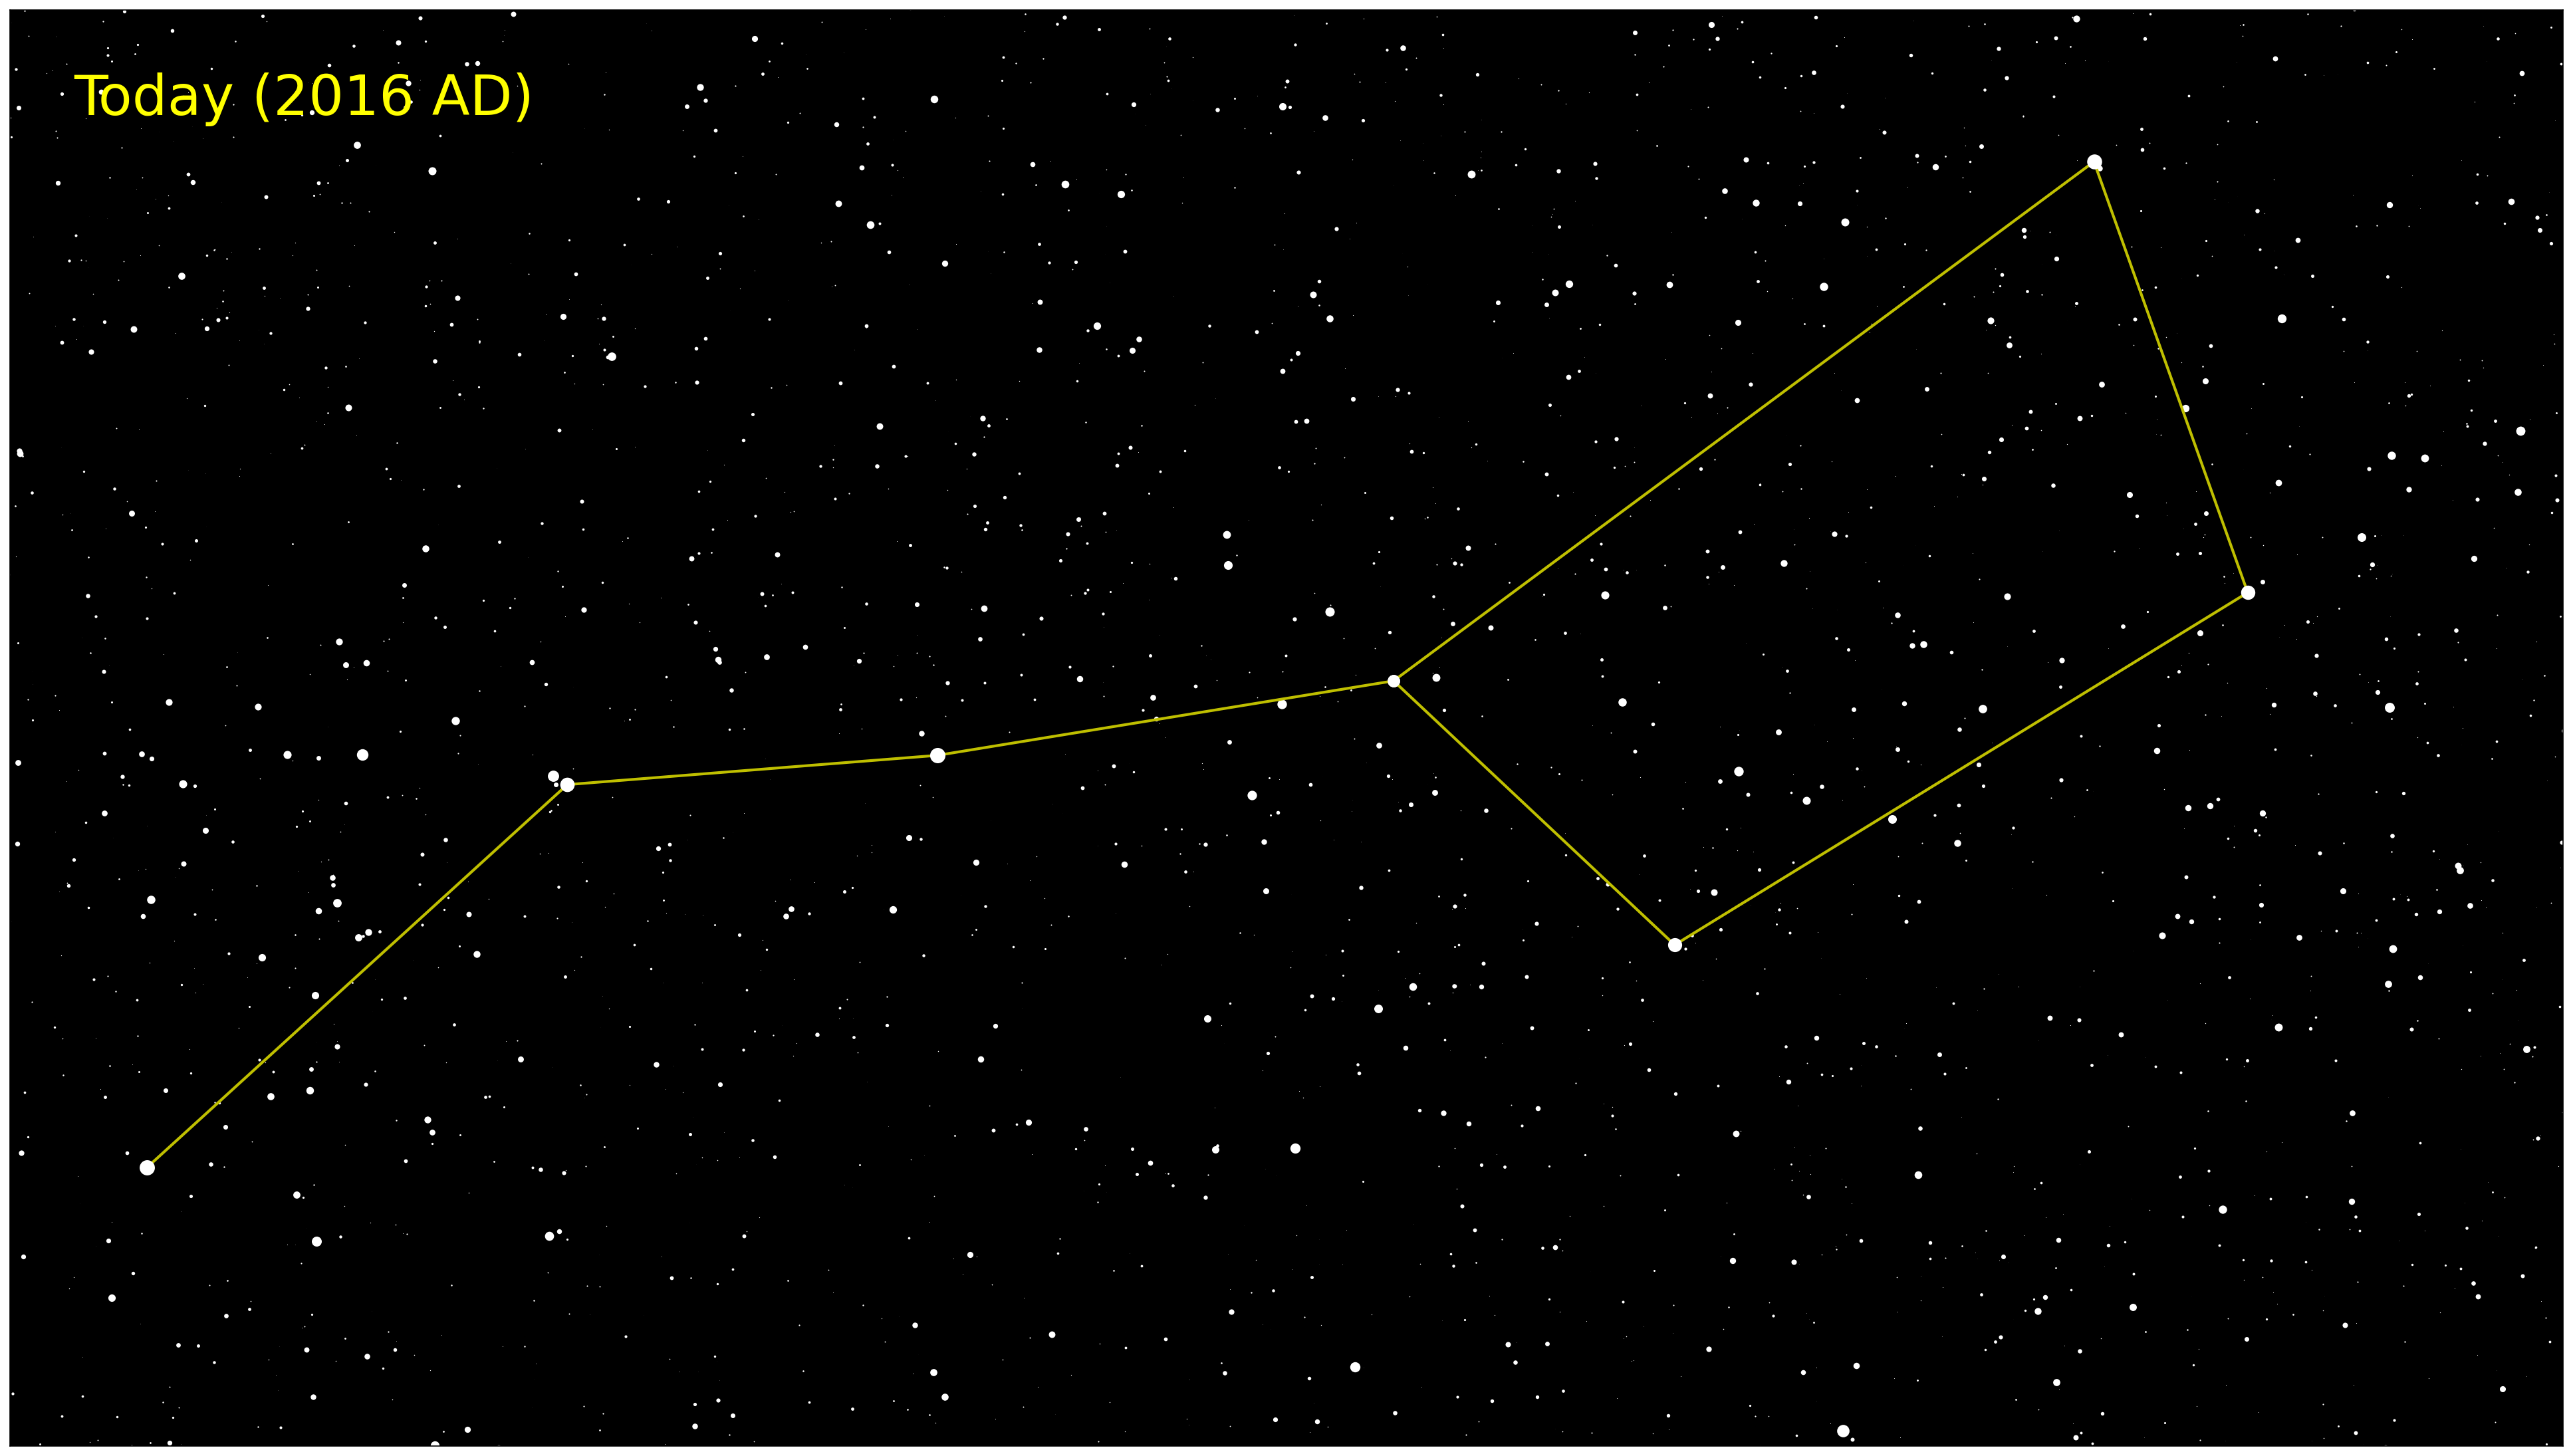

In [25]:
fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.set_position([0, 0, 1, 1])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('black')

halfWidth = 15
ax.set_xlim(halfWidth,-halfWidth)
ax.set_ylim(-halfWidth/aspect,halfWidth/aspect)

for i in range(len(xi)):
    ax.plot(xi[i],eta[i],color='white',alpha=1,marker='o',ms=ms[i],mew=0)

for i in range(len(xiUMa)-1):
    ax.plot(xiUMa[i],etaUMa[i],color='white',alpha=1,marker='o',ms=msUMa[i],mew=0,zorder=10)
    
ax.plot(xiUMa,etaUMa,'y-',lw=2)

# Label

xlab = 0.95*halfWidth
ylab = 0.875*halfWidth/aspect
ax.text(xlab,ylab,f"Today ({int(gaiaEpoch)} AD)",fontsize=40,color='yellow',va='center',ha='left',zorder=10)

# Plot and save

fig.savefig('UMa_Today.png',bbox_inches='tight',pad_inches=0.0)

plt.show()

## Transform to other epochs

Apply proper motions to view this starfield at other epochs using the apply_space_motion() method.  Cannot go 
further in the past than -4799BC with these time algorithms (sorry)

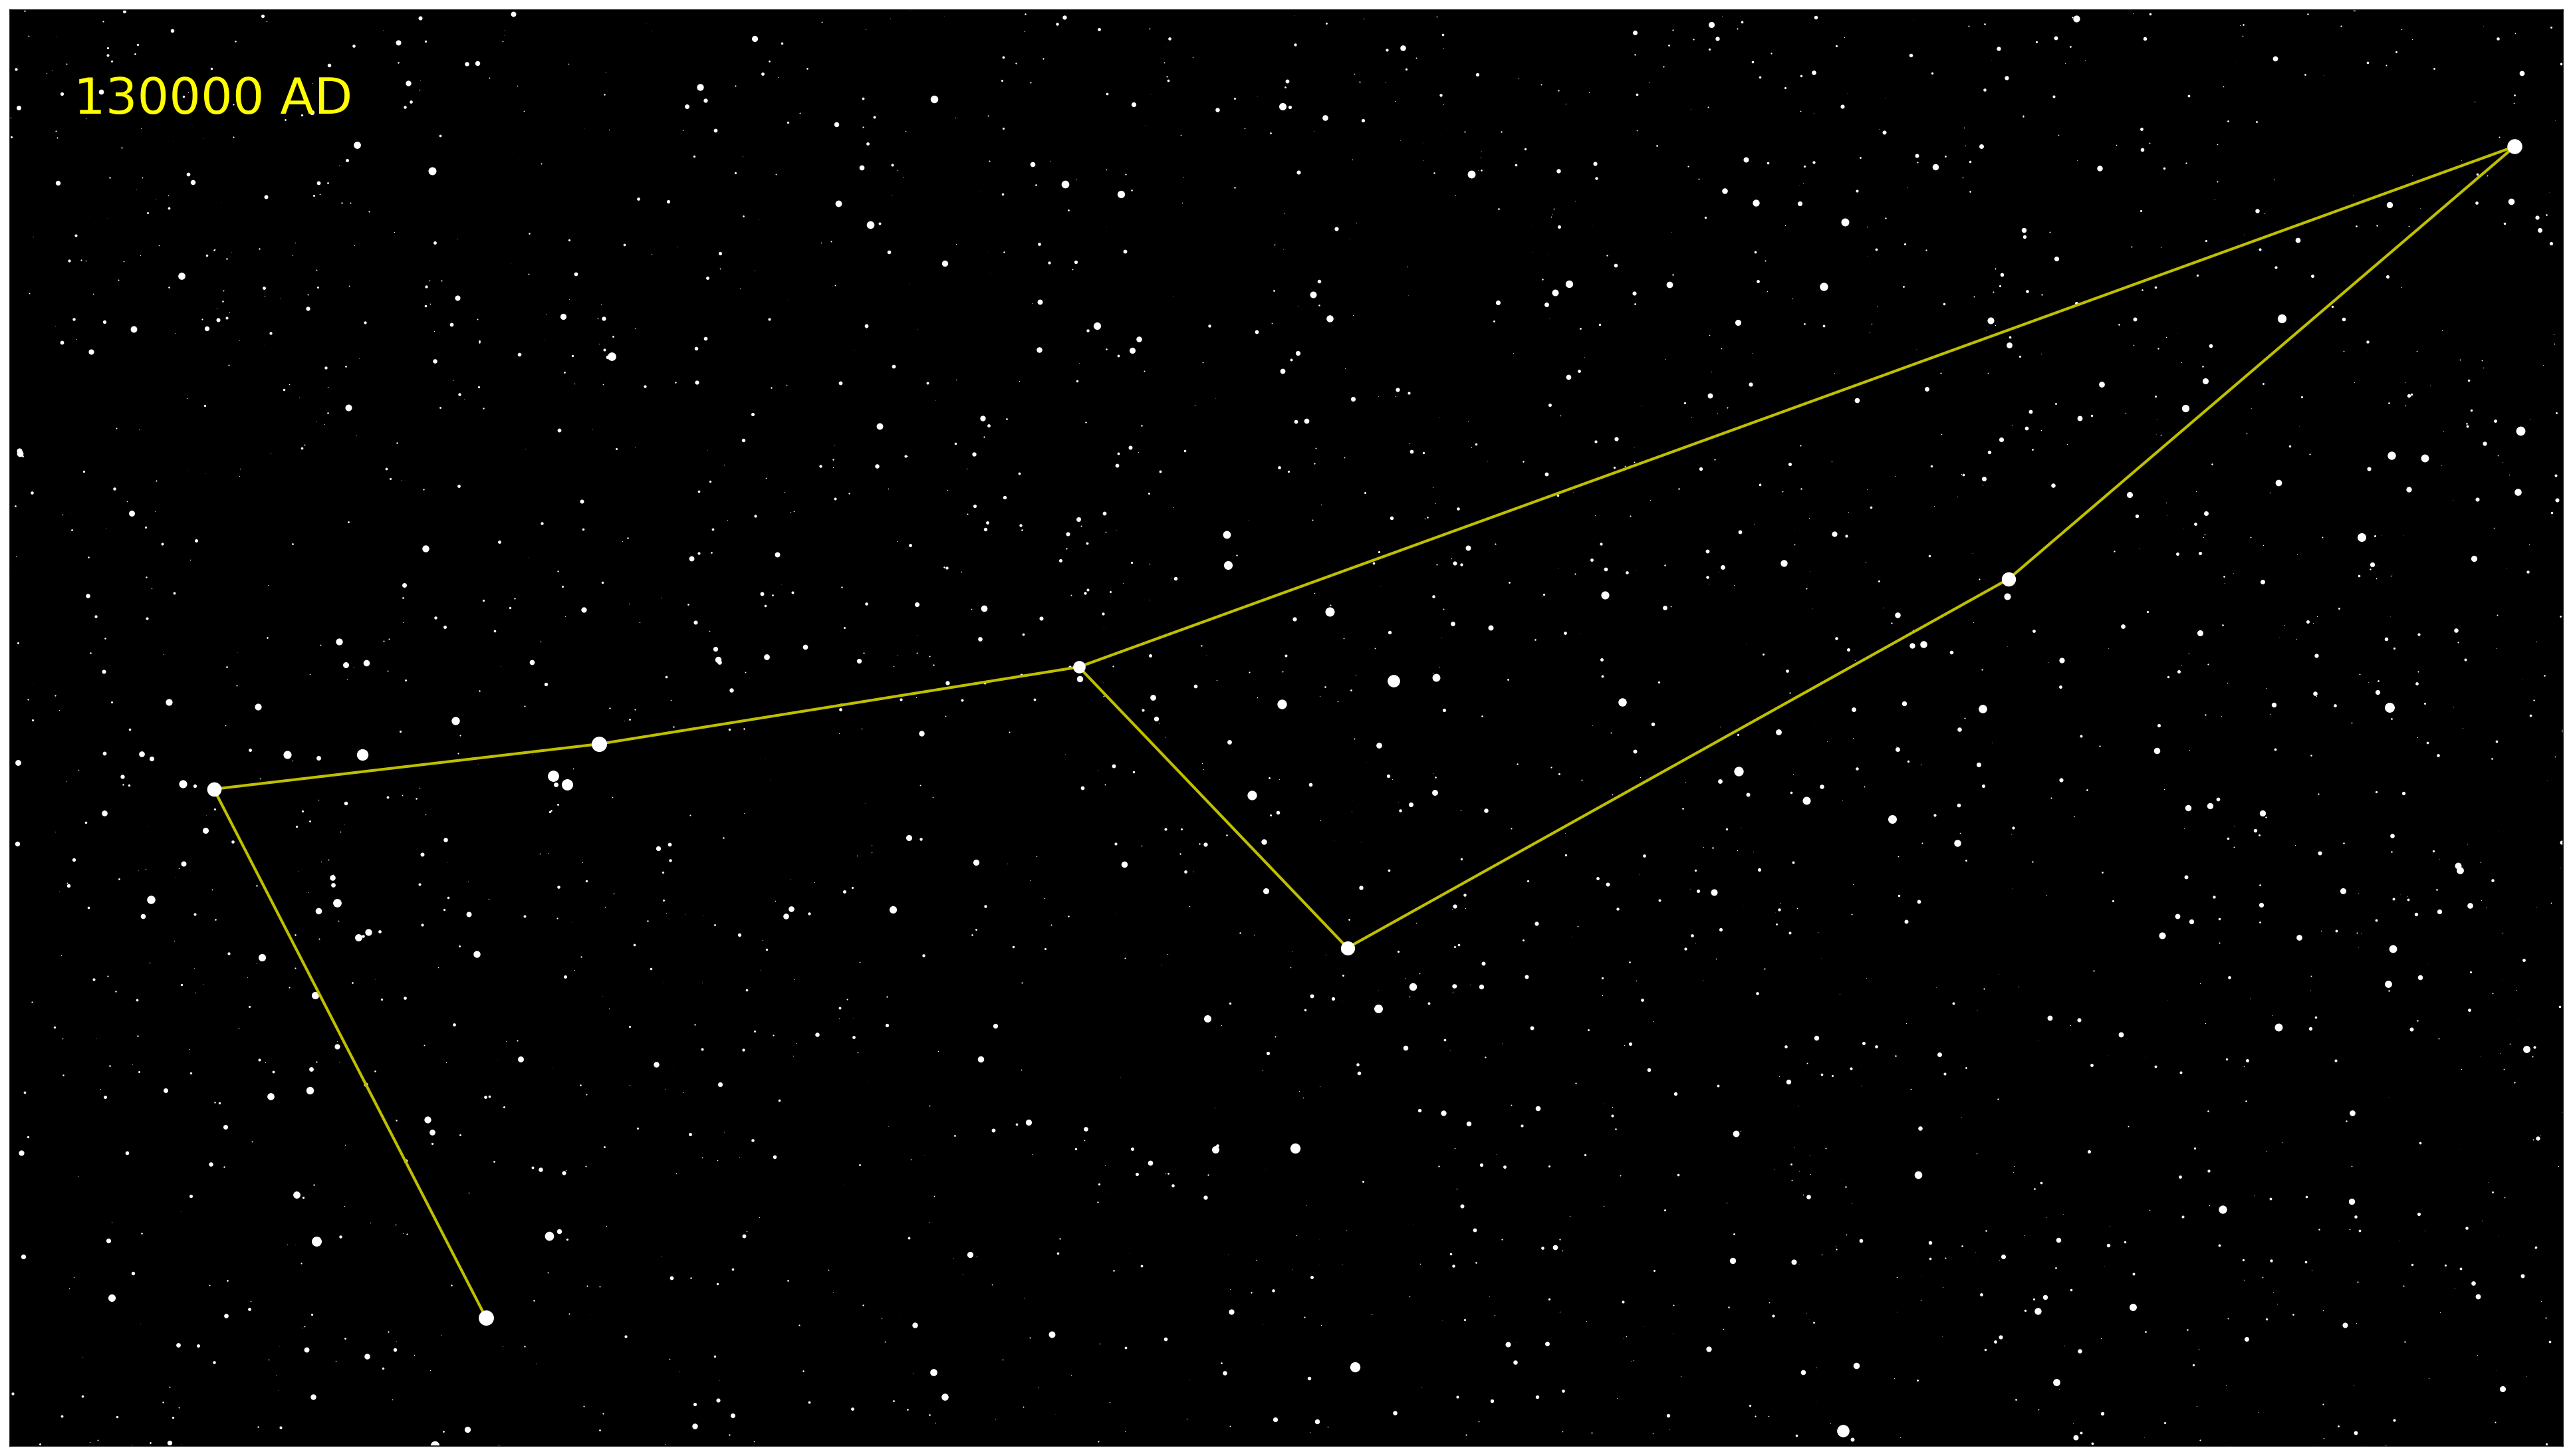

In [26]:
viewEpoch = 130000.0

if viewEpoch > 0:
    era = 'AD'
elif viewEpoch < 0:
    era = 'BC'
else:
    era = '1AD'
if abs(viewEpoch)>=10000:
    pngFile = 'UMa_%dk%s.png' % (int(abs(viewEpoch)/1000),era)
else:
    pngFile = 'UMa_%d%s.png' % (int(abs(viewEpoch)),era)

viewLabel = '%d %s' % (abs(viewEpoch),era)
    
newEpoch = Time(viewEpoch,format='decimalyear')

newStars = stars.apply_space_motion(newEpoch)
newConst = constel.apply_space_motion(newEpoch)

# Transform field to (xi,eta) coords centered on UMa

sky = newStars.transform_to(uma.skyoffset_frame())
xiSky = sky.lon
etaSky = sky.lat

# and same for the constellation proper

conUMa = newConst.transform_to(uma.skyoffset_frame())
xiUMa = conUMa.lon
etaUMa = conUMa.lat

# and plot 

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.set_position([0, 0, 1, 1])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('black')

halfWidth = 15
ax.set_xlim(halfWidth,-halfWidth)
ax.set_ylim(-halfWidth/aspect,halfWidth/aspect)

for i in range(len(xi)):
    ax.plot(xi[i],eta[i],color='white',alpha=1,marker='o',ms=ms[i],mew=0)

for i in range(len(xiUMa)-1):
    ax.plot(xiUMa[i],etaUMa[i],color='white',alpha=1,marker='o',ms=msUMa[i],mew=0,zorder=10)
    
ax.plot(xiUMa,etaUMa,'y-',lw=2)

# Label

xlab = 0.95*halfWidth
ylab = 0.875*halfWidth/aspect
ax.text(xlab,ylab,viewLabel,fontsize=36,color='yellow',va='center',ha='left',zorder=10)

# show and save the plot

plt.savefig(pngFile,bbox_inches='tight',pad_inches=0.0)

plt.show()